# RL Coursework 1

## Questions 1
a. Write out your personalised trace. Please use exactly the same format as in the example above.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

full_start_time = time.time()


cid = 1349379
cid = [int(x) for x in str(cid)]

states = [np.mod((cid[t] + 2), 4) for t in range(len(cid))]
rewards = [np.mod((cid[t]), 4) for t in range(len(cid))]

trace = [None]*(len(states)+len(rewards))
trace[::2] = states
trace[1::2] = rewards

print("The trace for the CID: {} is {}".format(cid, trace))


# Question 2

a. State your personalised reward state, p, and γ (1 pts)

In [4]:
class GridElement():
    def __init__(self, name=None, reward=None, location_coords=None, is_terminal=False, is_wall=False):
        self.location = location_coords
        self.reward = reward
        self.is_terminal = is_terminal
        self.is_wall = is_wall

    def __repr__(self):
        if self.is_wall:
            return '[ ]'
        return str(self.reward)
    
    def set_as_wall(self):
        self.is_wall = True
        return self

In [5]:
class NewGridWorld():
    def __init__(self, 
            absorbing_locs=None,
            special_rewards=None,
            p_transition=0.45,
            obstacle_locs=[(1,1), (2,3), (2, 5), (3,1), (4,1), (4,2), (4,4)],
            shape=(6,6)):
        self.reward_state_rew = reward_state_rew
        self.penalty_state_rew = penalty_state_rew

        ### Attributes defining the Gridworld #######
        # Shape of the gridworld
        self.shape = shape
        
        # Locations of the obstacles
        self.obstacle_locs = obstacle_locs
        self.absorbing_locs = absorbing_locs

        # Reward for all the other states
        self.default_reward = -1
        self.special_rewards = special_rewards

        # Starting location
        self.starting_loc = (1,0)
        
        # Action names
        self.action_names = {
            'North': 'N',
            'East': 'E',
            'South': 'S',
            'West': 'W'}
        self.action_names_list = ['N', 'E', 'S', 'W']
        self.action_size = len(self.action_names)
        
        # Randomizing action results: [1 0 0 0] to no Noise in the action results.
        self.action_randomizing_array = [0.8, 0.1, 0.0 , 0.1]
        self.p_transition = p_transition

        # Measuring convergence via delta's
        self.delta_history = []
        
        ############################################


        #### Internal State  ####
        
        # Get attributes defining the world
        state_size, T, R, absorbing, locs, neighbors = self.build_grid_world()
        
        # Number of valid states in the gridworld (there are 22 of them)
        self.state_size = state_size
        
        # Transition operator (3D tensor)
        self.T = T
        
        # Reward function (3D tensor)
        self.R = R
        
        # Absorbing states
        self.absorbing = absorbing
        
        # The locations of the valid states
        self.locs = locs

        # Neighbors
        self.neighbors = neighbors
        
        # Number of the starting state
        self.starting_state = self.loc_to_state(self.starting_loc, locs)
        
        # Locating the initial state
        self.initial = np.zeros((1,len(locs)))
        self.initial[0,self.starting_state] = 1
        
        
        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape)
        for ob in self.obstacle_locs:
            self.walls[ob]=1
            
        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1
        
        # Placing the rewarders on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for i, rew in enumerate(self.absorbing_locs):
            self.rewarders[rew] = self.special_rewards[i]
        
        #Illustrating the grid world
        # self.paint_maps()
        ################################


    ####### Getters ###########
    
    def get_transition_matrix(self):
        return self.T
    
    def get_reward_matrix(self):
        return self.R
    
    ########################


    ####### Methods #########
    ##########################


    # DRAW

    ############# PLOTTING AND DRAWING #############
    def draw_learningcurve_repvars(self, all_curves, title_text='', var_labels=[], axislabels=('Episodes', 'Mean return'), new_fig=False, save=None):
        """ Plot different curves on the same plot with repeats.
        all_curve[var, rep, curve_values] """
        
        if not new_fig:
            plt.figure()
        for var_num, var_curves in enumerate(all_curves):
            if new_fig:
                plt.figure()
            mean_curve = np.average(var_curves, axis=0)
            std_curve = np.std(var_curves, axis=0) 

            label = var_labels[var_num]
            
            plt.plot(mean_curve, label=label)
            plt.fill_between(list(range(len(mean_curve))), (mean_curve - std_curve), (mean_curve + std_curve), alpha=0.6)
        
            plt.title(title_text)
            plt.xlabel(axislabels[0])
            plt.ylabel(axislabels[1])
            if new_fig:
                plt.legend(loc="upper left")

        if not new_fig:
            plt.legend(loc="upper left")

        if save:
            plt.savefig(save)
        # plt.show()

    def draw_learning_curve_together(self, all_curves, title_text='', labels=[], repeats=False, new_fig=False, multiple_curves=False, save=None):
        """ Plot multiple learning curves on same plot """
        plt.figure()
        num_separate_curves = len(all_curves) if multiple_curves else 1
        for c in range(num_separate_curves):
            some_curves = all_curves[c] if num_separate_curves>1 else all_curves
            for i, curves in enumerate(some_curves):
                label = labels[i] if labels else None
                # title_text = title_text+label if title_text else ''
                self.draw_learning_curve(curves, title_text=title_text, label=label, new_fig=new_fig, repeats=repeats)
        plt.title(title_text)
        plt.xlabel('Episodes')
        plt.ylabel('Mean discounted rewards')
        if save:
            plt.savefig(save)
        # plt.show()

    def draw_learning_curve(self, all_mean_rewards, title_text='', label='', new_fig=True, repeats=True, axislabels=('Episodes','Mean discounted rewards'), save=None):
        """ Draw the rewards collected per episode """
        mean_mean_rewards = np.average(all_mean_rewards, axis=0) if repeats else all_mean_rewards 
        std_mean_rewards = np.std(all_mean_rewards, axis=0) if repeats else 0
        if new_fig:
            plt.figure()
            plt.title(title_text)
            plt.xlabel(axislabels[0])
            plt.ylabel(axislabels[1])
        plt.plot(mean_mean_rewards, label=label)
        if repeats:
            plt.fill_between(list(range(len(mean_mean_rewards))), (mean_mean_rewards - std_mean_rewards), (mean_mean_rewards + std_mean_rewards), alpha=0.6)
        if new_fig:
            if save:
                plt.savefig(save)
            # plt.show()

    def draw_deterministic_policy(self, Policy, V=None, title='Policy grid', save=None):
        # Draw a deterministic policy
        # The policy needs to be a np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure()
        
        walls, absorbers, rewarders, value_states = self.get_world_vars_plotting(V)
        plt.imshow(walls + absorbers + value_states + rewarders, cmap=cm.RdYlBu_r)
        # plt.hold('on')
        for state, action in enumerate(Policy):
            if(self.absorbing[0,state]):
                policy_text = 'Absorbing'
                location = self.locs[state]
                plt.text(location[1], location[0], policy_text, ha='center', va='center')
                continue
            arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
            action = np.argmax(Policy[state, :])
            action = int(action)
            action_arrow = arrows[action]

            location = self.locs[state]
            plt.text(location[1], location[0], action_arrow, ha='center', va='center')
            plt.title(title)

        if save:
            plt.savefig(save)
        # plt.show()

    def draw_stochastic_policy(self, Policy, V=None, title='Policy for Grid World', save=None):
        # Draw a stochastic policy
        # The policy needs to be a np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure(figsize=(12,8))  # 

        walls, absorbers, rewarders, value_states = self.get_world_vars_plotting(V)
        plt.imshow(walls + absorbers + value_states + rewarders, cmap=cm.RdYlBu_r)  # Spectral_r coolwarm
        # plt.hold('on')
        for state, action in enumerate(Policy):
            if(self.absorbing[0,state]):
                policy_text = 'Absorbing'
                location = self.locs[state]
                plt.text(location[1], location[0], policy_text, ha='center', va='center')
                continue
            arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
            action = np.argmax(Policy[state, :])
            action = int(action)
            action_arrow = arrows[action]

            location = self.locs[state]

            # Show the probability for each action (first 4 digits)
            Policy = np.around(Policy, decimals=4)
            policy_text = ['{}\n'.format(action_prob) for action_prob in Policy[state, :]]
            policy_text = ''.join(policy_text)
            policy_text = action_arrow + '\n' + policy_text
            plt.text(location[1], location[0], policy_text, ha='center', va='center')
        
        plt.title(title)
        plt.colorbar()
        if save:
            plt.savefig(save)
        # plt.show()

    def draw_stochastic_policy_grid(self, Policies, Values, titles, n_columns, n_lines):
        # Draw grid of policies

        plt.figure(figsize=(35,8))
        vmin = np.min(Values)
        vmax = np.max(Values)
        for subplot in range(len(Policies)): # Go through all policies
            ax = plt.subplot(n_columns, n_lines, subplot+1)         # Create a subplot for each policy
            Policy = Policies[subplot]
            V = Values[subplot]
            for state, action in enumerate(Policy):
                walls, absorbers, rewarders, value_states = self.get_world_vars_plotting(V)
                ax.imshow(walls + absorbers + value_states + rewarders, cmap=cm.RdYlBu_r, aspect='auto', vmin=vmin, vmax=vmax)  # Create the graph of the grid

                if(self.absorbing[0,state]):
                    continue
                arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
                action = np.argmax(Policy[state, :])
                action = int(action)
                action_arrow = arrows[action]

                location = self.locs[state]

                # Show the probability for each action (first 4 digits)
                Policy = np.around(Policy, decimals=4)
                policy_text = ['{}\n'.format(action_prob) for action_prob in Policy[state, :]]
                policy_text = ''.join(policy_text)
                policy_text = action_arrow + '\n' + policy_text
                plt.text(location[1], location[0], policy_text, ha='center', va='center')
                plt.colorbar()
            ax.title.set_text(titles[subplot]) # Set the title for the graoh given as argument

        # plt.show()

    def get_world_vars_plotting(self, V):
        """ Helper var for making walls etc. look good """
        walls = self.show_as_nan(self.walls)
        absorbers_idx = np.where(self.absorbers != 0)
        absorbers_idx = zip(absorbers_idx[0], absorbers_idx[1])
        rewarders = self.rewarders
        absorbers = self.absorbers
        for i, j in absorbers_idx:
            rewarders[i, j] = 0
            absorbers[i, j] = 0
        value_states = self.get_value_state_grid(V)

        return walls, absorbers, rewarders, value_states

    def get_value_state_grid(self, V):
        """ Convert V to GridWorld format """
        value_states = np.zeros(self.absorbers.shape)
        if np.any(V):
            for flat_idx in range(len(V)):
                state_loc = self.state_to_loc(flat_idx, self.locs)
                value_states[state_loc[0], state_loc[1]] = V[flat_idx]
            # for i in range(value_states.shape[0]):
            #     for j in range(value_states.shape[1]):
            #         flat_idx = i*value_states.shape[1] + j
            #         state_loc = self.state_to_loc(flat_idx)
            #         value_states[i, j] = V[flat_idx]
        return value_states

    def show_as_nan(self, grid_elements):
        # For plotting function, show the non-zero elements here as nan
        grid_elements[np.nonzero(grid_elements)] = np.nan
        return grid_elements

    def draw_value(self, Value, title='Value for Grid World', save=None):
        # Draw a policy value function
        value_states = self.get_value_state_grid(Value)
        
        plt.figure()
        walls, absorbers, rewarders, value_states = self.get_world_vars_plotting(Value)
        vmin=np.min(Value)
        vmax=np.max(Value)
        plt.imshow(walls +absorbers +rewarders +value_states, cmap=cm.RdYlBu_r, vmin=vmin, vmax=vmax)  # Create the graph of the grid (leave +self.rewarders)
        for state, value in enumerate(Value):
            if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
                continue
            location = self.locs[state] # Compute the value location on graph
            plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    
        plt.title(title)
        plt.colorbar()
        if save:
            plt.savefig(save)
        # plt.show()

    def draw_delta_history(self):
        # Draw the progression of deltas with each epoch
        fig = plt.figure()

        plt.plot(self.delta_history)
        plt.title('Value convergence')
        plt.xlabel('Epoch')
        plt.ylabel('Delta')
        # plt.show()

    def draw_rewards(self, reward_episode_tracking, use_first_visit=True, save=None):
        # Plot the mean total rewards per episode vs. episodes
        fig = plt.figure()

        visit_type = '(First-visit)' if use_first_visit else '(Every-visit)'

        plt.plot(reward_episode_tracking)
        plt.title('Mean rewards collected per episode {}'.format(visit_type))
        plt.xlabel('Episode')
        plt.ylabel('Mean Reward')
        if save:
            plt.savefig(save)
        # plt.show()

    def draw_deterministic_policy_grid(self, Policy, Values, titles, n_columns, n_lines, save=None):
        # Draw a grid of deterministic policy
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure(figsize=(12,12))
        walls, absorbers, rewarders, value_states = self.get_world_vars_plotting(Values[0])
        vmin=np.min(Values)
        vmax=np.max(Values)
        im = plt.imshow(walls +absorbers +rewarders +value_states, cmap=cm.RdYlBu_r, vmin=vmin, vmax=vmax)
        for subplot in range (len(Policy)): # Go through all policies
            ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
            PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
            Value = Values[subplot]
            walls, absorbers, rewarders, value_states = self.get_world_vars_plotting(Value)
            ax.imshow(walls +absorbers +rewarders +value_states, cmap=cm.RdYlBu_r, vmin=vmin, vmax=vmax)
            for state, action in enumerate(Policy[subplot]):
                if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
                    continue
                arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
                action = np.argmax(action)
                action = int(action)
                action_arrow = arrows[action] # Take the corresponding action
                location = self.locs[state] # Compute its location on graph
                plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
            ax.title.set_text(titles[subplot]) # Set the title for the graoh given as argument
            plt.colorbar(im, ax=ax)
        if save:
            plt.savefig(save)
        # plt.show()

    def draw_value_grid(self, Value, titles, n_columns, n_lines, save=None):
        # Draw a grid of value function
        plt.figure(figsize=(12,12))
        walls, absorbers, rewarders, value_states = self.get_world_vars_plotting(Value[0])
        vmin=np.min(Value)
        vmax=np.max(Value)
        im = plt.imshow(walls +absorbers +rewarders +value_states, cmap=cm.RdYlBu_r, vmin=vmin, vmax=vmax)
        for subplot in range (len(Value)): # Go through all values
            ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
            walls, absorbers, rewarders, value_states = self.get_world_vars_plotting(Value[subplot])
            ax.imshow(walls +absorbers +rewarders +value_states, cmap=cm.RdYlBu_r, vmin=vmin, vmax=vmax)
            for state, value in enumerate(Value[subplot]):
                if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
                    continue
                location = self.locs[state] # Compute the value location on graph
                plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
            ax.title.set_text(titles[subplot]) # Set the title for the graoh given as argument
            plt.colorbar(im, ax=ax)
        if save:
            plt.savefig(save)
        # plt.show()


    ##########################

    # DRAW
    
    


    ########### Internal Helper Functions #####################
    def paint_maps(self):
        # Helper function to print the grid word used in __init__
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(self.walls)
        plt.title('Obstacles')
        plt.subplot(1,3,2)
        plt.imshow(self.absorbers)
        plt.title('Absorbing states')
        plt.subplot(1,3,3)
        plt.imshow(self.rewarders)
        plt.title('Reward states')
        plt.show()

    def build_grid_world(self):
        # Get the locations of all the valid states, the neighbors of each state (by state number),
        # and the absorbing states (array of 0's with ones in the absorbing states)
        locations, neighbors, absorbing = self.get_topology()
        
        # Get the number of states
        S = len(locations)
        
        # Initialise the transition matrix
        T = np.zeros((S,S,self.action_size))

        # Possible probabilities of transitions
        self_prob = self.p_transition  # self.action_randomizing_array[effect]
        neighbor_prob = (1 - self.p_transition) / (self.action_size - 1)
        
        # To fill T, we need to check if the current action leads us to the
        # next state. 
        # For each prior state, choose an action, then assign probs to each post_state
        for prior_state in range(S):
            for action in range(self.action_size):
                for effect in range(self.action_size):
                    post_state = int(neighbors[prior_state, effect])

                    # If this is the desired action
                    if action == effect:
                        T[post_state,prior_state,action] = self_prob
                    else:
                        T[post_state,prior_state,action] = neighbor_prob

        # Build the reward matrix
        R = self.default_reward*np.ones((S,S,self.action_size))
        for i, sr in enumerate(self.special_rewards):
            post_state = self.loc_to_state(self.absorbing_locs[i],locations)
            R[post_state,:,:]= sr

        return S, T,R,absorbing,locations, neighbors
    

    def get_topology(self):
        height = self.shape[0]
        width = self.shape[1]
        
        index = 1 
        locs = []
        neighbor_locs = []
        
        for i in range(height):
            for j in range(width):
                # Get the locaiton of each state
                loc = (i,j)
                
                #And append it to the valid state locations if it is a valid state (ie not absorbing)
                if(self.is_location(loc)):
                    locs.append(loc)
                    
                    # Get an array with the neighbors of each state, in terms of locations
                    local_neighbors = [self.get_neighbor(loc,direction) for direction in list(self.action_names.values())]
                    neighbor_locs.append(local_neighbors)
                
        # translate neighbor lists from locations to states
        num_states = len(locs)
        state_neighbors = np.zeros((num_states,4))
        
        for state in range(num_states):
            for direction in range(4):
                # Find neighbor location
                nloc = neighbor_locs[state][direction]
                
                # Turn location into a state number
                nstate = self.loc_to_state(nloc,locs)
      
                # Insert into neighbor matrix
                state_neighbors[state,direction] = nstate
                
    
        # Translate absorbing locations into absorbing state indices
        absorbing = np.zeros((1,num_states))
        for a in self.absorbing_locs:
            absorbing_state = self.loc_to_state(a,locs)
            absorbing[0,absorbing_state] =1
        
        return locs, state_neighbors, absorbing 


    def loc_to_state(self,loc,locs):
        #takes list of locations and gives index corresponding to input loc
        return locs.index(tuple(loc))

    def state_to_loc(self, state, locs):
        #convert given (valid) state number to its grid location
        return locs[state]

    def is_location(self, loc):
        # It is a valid location if it is in grid and not obstacle
        if(loc[0]<0 or loc[1]<0 or loc[0]>self.shape[0]-1 or loc[1]>self.shape[1]-1):
            return False
        elif(loc in self.obstacle_locs):
            return False
        else:
            return True
            
    def get_neighbor(self,loc,direction):
        #Find the valid neighbors (ie that are in the grif and not obstacle)
        i = loc[0]
        j = loc[1]
        
        nr = (i-1,j)
        ea = (i,j+1)
        so = (i+1,j)
        we = (i,j-1)
        
        # If the neighbor is a valid location, accept it, otherwise, stay put
        if(direction == self.action_names['North'] and self.is_location(nr)):
            return nr
        elif(direction == self.action_names['East'] and self.is_location(ea)):
            return ea
        elif(direction == self.action_names['South'] and self.is_location(so)):
            return so
        elif(direction == self.action_names['West'] and self.is_location(we)):
            return we
        else:
            #default is to return to the same location
            return loc

    def states_to_direction(self, prior, post):
        """ Return the direction needed to go from prior state to post state.
        Aka the direction you are facing when going to post state from prior. """

        prior_loc = self.state_to_loc(prior, self.locs)
        post_loc = self.state_to_loc(post, self.locs)
        # print('prior_loc', prior_loc)
        # print('post_loc', post_loc)

        if prior_loc[0] < post_loc[0]:
            return self.action_names_list.index(self.action_names['North'])
        if prior_loc[1] < post_loc[1]:
            return self.action_names_list.index(self.action_names['East'])
        if prior_loc[0] > post_loc[0]:
            return self.action_names_list.index(self.action_names['South'])
        if prior_loc[1] > post_loc[1]:
            return self.action_names_list.index(self.action_names['West'])
        else:
            return np.random.randint(0, self.action_size)

    # def convert_index_to_loc(self, idx, row_num, col_num):
    #     row_idx = idx // row_num
    #     col_idx = idx % col_num
    #     return (row_idx, col_idx)

        
################## End world class #########################         


In [6]:
################## DP class #########################         

class DP_Policy(NewGridWorld):
    
    def __init__(self, 
            absorbing_locs=None,
            special_rewards=None,
            p_transition=0.45
            ):
        super(DP_Policy, self).__init__(absorbing_locs, special_rewards, p_transition)

    ####### Methods #########
    def value_iteration(self, discount = 0.9, threshold = 0.0001):
        ## Slide 144 of the lecture notes for the algorithm ##
        
        # Transition and reward matrices, both are 3d tensors, c.f. internal state
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        # Initialisation
        epochs = 0
        delta = threshold # Setting value of delta to go through the first breaking condition
        V = np.zeros(self.state_size) # Initialise values at 0 for each state

        while delta >= threshold:
            epochs += 1 # Increment the epoch
            delta = 0 # Reinitialise delta value

            # For each state
            for state_idx in range(self.state_size):

                # If not an absorbing state
                if not(self.absorbing[0,state_idx]):
                  
                    # Store the previous value for that state
                    old_V = V[state_idx] 

                    # Compute Q value
                    Q = np.zeros(4) # Initialise with value 0
                    for state_idx_prime in range(self.state_size):
                        current_return = R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime]
                        Q += T[state_idx_prime,state_idx,:] * current_return
                
                    # Set the new value to the maximum of Q
                    V[state_idx]= np.max(Q) 

                    # Compute the new delta
                    delta = max(delta, np.abs(old_V - V[state_idx]))
                    # delta = max(abs(Vnew-V))
            
        # When the loop is finished, fill in the optimal policy
        optimal_policy = np.zeros((self.state_size, self.action_size)) # Initialisation

        # For each state
        for state_idx in range(self.state_size):
            # If not an absorbing state
            if not(self.absorbing[0,state_idx]):

                # Compute Q value
                Q = np.zeros(4)
                for state_idx_prime in range(self.state_size):
                    Q += T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                
                # The action that maximises the Q value gets probability 1
                optimal_policy[state_idx, np.argmax(Q)] = 1 

        optimal_V = V

        return optimal_policy, optimal_V, epochs


    def policy_iteration(self, policy, discount=0.9, threshold = 0.0001):
        """ Policy Improvement / Iterative policy to get optimal value and policy. Full sweep. """
        epochs = [0]
        V = np.zeros(policy.shape[0])
        returns = [0]

        R = self.get_reward_matrix()
        T = self.get_transition_matrix()

        # Prepare plot
        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        # Ln = ax.plot(values)
        # ax.plot(returns)
        # ax.set_xlim([0,20])
        # plt.ion()
        # plt.imshow(self.walls+self.rewarders +self.absorbers)
        # plt.show()  

        is_policy_stable = False
        while (not is_policy_stable) and (epochs[-1] < 2000):
            is_policy_stable = True

            V, epochs_eval = self.policy_evaluation(policy, threshold, discount)

            epochs.append(epochs[-1] + epochs_eval)
            returns.append(np.sum(V))
            # print('Iteration Epochs:', epochs[-1])

            # Policy iteration
            for state_idx in range(policy.shape[0]):
                # If not an absorbing state
                if not(self.absorbing[0,state_idx]):

                    # Store the old action
                    old_action = np.argmax(policy[state_idx,:])

                    # Compute Q value
                    Q = np.zeros(4) # Initialise with value 0
                    for state_idx_prime in range(policy.shape[0]):
                        current_return = R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime]
                        Q += T[state_idx_prime,state_idx,:] * current_return

                    # Compute corresponding policy
                    new_policy = np.zeros(4)
                    new_policy[np.argmax(Q)] = 1  # The action that maximises the Q value gets probability 1
                    policy[state_idx] = new_policy
                    
                    if old_action != np.argmax(policy[state_idx]):
                        is_policy_stable = False

            ### PLOT V progress ###
            # ax.plot(returns, epochs)
            # self.draw_value(V)
            # Ln.set_ydata(values)
            # Ln.set_xdata(epochs)
            # plt.pause(1)

        return policy, V, epochs


    def policy_evaluation(self, policy, threshold, discount):
        
        # Make sure delta is bigger than the threshold to start with
        delta= 2*threshold
        
        # Measuring convergence via delta's
        self.delta_history = []
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()
        
        # The value is initialised at 0
        V = np.zeros(policy.shape[0])
        # Make a deep copy of the value array to hold the update during the evaluation
        Vnew = np.copy(V)

        epoch = 0        
        # While the Value has not yet converged do:
        while delta>threshold:
            epoch += 1

            for state_idx in range(policy.shape[0]):
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):
                    continue   
                
                # Accumulator variable for the Value of a state
                tmpV = 0
                for action_idx in range(policy.shape[1]):
                    # Accumulator variable for the State-Action Value
                    tmpQ = 0
                    for state_idx_prime in range(policy.shape[0]):
                        tmpQ = tmpQ + T[state_idx_prime,state_idx,action_idx] * (R[state_idx_prime,state_idx, action_idx] + discount * V[state_idx_prime])
                    
                    tmpV += policy[state_idx,action_idx] * tmpQ
                    
                # Update the value of the state
                Vnew[state_idx] = tmpV
            
            # After updating the values of all states, update the delta
            delta = max(abs(Vnew-V))
            self.delta_history.append(delta)
            # and save the new value into the old
            V=np.copy(Vnew)
            
        return V, epoch

    ##########################

In [7]:
cid_nums = 379
x = int(str(cid_nums)[0])
y = int(str(cid_nums)[1])
z = int(str(cid_nums)[2])

p = 0.25 + 0.5 * (x+1)/10
gamma = 0.2 + 0.5 * y/10
j = np.mod((z+1), 3) + 1
threshold = 0.0001

print("The value of p is {} and the value of gamma is {}".format(p, gamma))
print("The reward state is s_{}".format(j))

The value of p is 0.45 and the value of gamma is 0.55
The reward state is s_2


b. Dynamic Programming (with full world knowledge) (24 pts)

1. Compute the optimal value function and the optimal policy using Dynamic Programming.
Briefly state how you solved the problem, including any parameters that you set or assumptions you made.

4. Briefly discuss how the value of your γ and p have influenced the optimal value function
and optimal policy in your personal Grid World. In particular, you may investigate the
effect of having a value of p < 0.25, p = 0.25 or p > 0.25, and similarly γ < 0.5 or γ > 0.5.

In [8]:
# Creating GridWorld
reward_state_rew = ((1, 2), 10)     # State 2
penalty_state_rew = ((4, 3), -100)  # State 11

absorbing_locs = [reward_state_rew[0], penalty_state_rew[0]]
special_rewards = [reward_state_rew[1], penalty_state_rew[1]]

# p = 1

dp_world = DP_Policy(absorbing_locs=absorbing_locs, special_rewards=special_rewards, p_transition=p)

# Compute optimal value function
Policy = np.zeros((dp_world.state_size, dp_world.action_size))

policy_opt_DPpit, V_optimal_DPpit, epochs_DPpit = dp_world.policy_iteration(Policy, discount=gamma, threshold=threshold)
policy_opt_DPvit, V_optimal_DPvit, epochs_DPvit = dp_world.value_iteration(gamma, threshold)

# dp_world.draw_stochastic_policy(policy_opt_DPpit, V_optimal_DPpit, title=r'DP: Policy iteration, $\gamma$={} threshold={}'.format(gamma, threshold), save='DP_pit_policy-world.png')
# dp_world.draw_stochastic_policy(policy_opt_DPvit, V_optimal_DPvit, title=r'DP: Value iteration, $\gamma$={} threshold={}'.format(gamma, threshold), save='DP_vit_policy-world.png')

if np.all(policy_opt_DPpit == policy_opt_DPvit):
    print("The policy iteration and value iteration both reached the same optimal policy.")

print('\n2.b.4 Observe change of p and gamma')
start_time = time.time()
p_collection = [0.1, 0.25, 0.5] 
gamma_collection = [0.3, 0.5, 0.7]
Ps = p_collection * len(gamma_collection)
gammas = np.sort(gamma_collection * len(p_collection))
policies_dp = []
values_dp = []
titles = []
for p_, gamma_ in zip(Ps, gammas):
    dp_world = DP_Policy(absorbing_locs=absorbing_locs, special_rewards=special_rewards, p_transition=p_)
    policy_opt_DPvit, V_optimal_DPvit, epochs_DPvit = dp_world.value_iteration(gamma_, threshold)
    policies_dp.append(policy_opt_DPvit)
    values_dp.append(V_optimal_DPvit)
    titles.append(r'p={} $\gamma$={}'.format(p_, gamma_))
# dp_world.draw_deterministic_policy_grid(policies_dp, values_dp, titles, n_columns=len(p_collection), n_lines=len(gamma_collection), save='DP_policy_grid.png')
dp_world.draw_value_grid(values_dp, titles=titles, n_columns=len(p_collection), n_lines=len(gamma_collection), save='DP_value_grid.png')

print('2.b.4 took {}s'.format(time.time() - start_time))

Iteration Epochs: 1
Iteration Epochs: 23
Iteration Epochs: 42
Iteration Epochs: 62


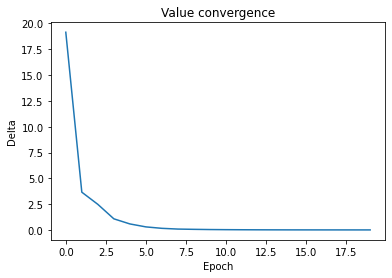

The policy iteration and value iteration both reached the same optimal policy.


In [9]:
# Compute optimal value function
Policy = np.zeros((world.state_size, world.action_size))

threshold = 0.001
gamma = 0.9
V, Policy, epochs = world.policy_iteration(Policy, discount=gamma, threshold=threshold)
optimal_policy, optimal_V, epochs = world.value_iteration(discount=gamma, threshold=threshold)

# Plot of optimal value and policy functions
world.draw_delta_history()

if np.all(optimal_policy == Policy):
    print("The policy iteration and value iteration both reached the same optimal policy.")

### c. Monte Carlo RL (15 pts)

1. Estimate the optimal value function using Monte Carlo (MC) reinforcement learning. Briefly
state how you solved the problem, including any parameters that you set or assumptions
you made

In [ ]:
class MC_World(NewGridWorld):
    def __init__(self,
            absorbing_locs=None,
            special_rewards=None,
            p_transition=0.45,
            use_first_visit=True,
            use_epsilon_greedy=True):
        super(MC_World, self).__init__(absorbing_locs, special_rewards, p_transition)

        self.use_first_visit = use_first_visit
        self.use_epsilon_greedy = use_epsilon_greedy
        self.reward_episode_tracking = []

        self.des_action_tracker = [0, 0]    # Keep track of how often desired action gets chosen

    def mc_iterative_optimisation(self, discount=0.45, epsilon_init=0.1, n=5, alpha=0.001, V_optimal=None, decay_alpha=False, decay_eps=True, batch=1):
        """ MC Iterative Learning to Control """
        # Q = np.zeros((self.state_size, self.action_size))
        Q = np.random.rand(self.state_size, self.action_size)
        policy = self.get_epsilon_greedy_policy(Q, epsilon_init)

        # Trackers
        total_returns = []
        all_rmse = []
        epsilon = epsilon_init
        
        for run in range(n):
            trace = self.run_episode(policy, epsilon)
            rewards_forward = [r[2] for r in trace]
            rewards_reverse = rewards_forward[::-1]

            state_a_tracker = np.zeros((self.state_size, self.action_size))

            # Rewrite
            # for i, (state, action, R) in enumerate(trace):
            #     G = 0 
            #     Rt = 0
            #     if (not state_a_tracker[state, action]) and self.use_first_visit:
            #         state_a_tracker[state, action] += 1
            #         G = self.get_discounted_rewards(rewards_forward[i::], discount)
            #         G = np.sum(G)
            #         for _, _, rev_R in reversed(trace[i::]):
            #             Rt = discount*Rt + rev_R

            #         if decay_alpha:
            #             alpha = 1 / state_a_tracker[state, action]
                    
            #         Q[state, action] += alpha * (G - Q[state, action])
            # /Rewrite

            ### OLD but works
            G = 0
            for i, (state, action, R) in enumerate(trace[::-1]):
                if state_a_tracker[state, action] and self.use_first_visit:
                    continue
                state_a_tracker[state, action] += 1

                # Find the points in the trace with this (s, a)
                reward_idx = self.get_occurence_idx(trace, state, action)
                if reward_idx==None:
                    # Use current index if first index not found
                    reward_idx = [(len(trace)-1) - i]

                # Calculate first-visit or every-visit returns 
                G = rewards_forward[reward_idx[0]:]
                G = np.sum(self.get_discounted_rewards(G, discount))
                Rt = G / state_a_tracker[state, action]
                
                if decay_alpha:
                    alpha = 1 / state_a_tracker[state, action]

                Q[state, action] += alpha * (Rt - Q[state, action])
            ### /OLD but works
            
            if (run % batch) == 0:
                policy = self.get_epsilon_greedy_policy(Q, epsilon)
            if decay_eps:
                epsilon = 1 / (i+1)

            # Record rewards
            total_return = 0
            for s, a, R in trace:   # Forward discounted
                total_return = discount*total_return + R
            # total_reward = self.get_discounted_rewards(rewards_reverse, discount)
            total_returns.append(np.sum(total_return))
            if np.any(V_optimal):   # Root Mean Square Error
                # V = self.get_optimal_value(Q, policy)
                # TODO: Changing V calculation
                V = np.max(Q, axis=1)
                rmse = self.get_rmse(V, V_optimal)
                all_rmse.append(rmse)
        
        # Value function
        V = self.get_optimal_value(Q, policy)

        # policy = self.get_greedy_policy(Q)
        return policy, V, total_returns, all_rmse

    # def mc_batch_optimisation(self, discount=0.45, epsilon_init=0.1, batch=1, n=5, total_runs=10, alpha=0.001, V_optimal=None):
    #     """ MC Batch Learning to Control """
    #     Q = np.zeros((self.state_size, self.action_size))
    #     policy = self.get_epsilon_greedy_policy(Q, epsilon_init)

    #     # Trackers
    #     total_rewards = []
    #     returns = []
    #     all_rmse = []
    #     epsilon = epsilon_init
    #     for run in range(total_runs):
    #         for b in range(batch):
    #             Returns = [[[] for i in range(self.action_size)] for i in range(self.state_size)]
    #             for i in range(n):
    #                 # New episode
    #                 trace = self.run_episode(policy, epsilon)
    #                 rewards_forward = [r[2] for r in trace]
    #                 rewards_reverse = rewards_forward[::-1]

    #                 total_reward = []
    #                 state_a_tracker = np.zeros(self.state_size)
    #                 G = 0

    #                 # Old
    #                 # state_a_tracker = np.zeros((self.state_size, self.action_size))
    #                 # for state, action, reward in trace:
    #                 #     if self.use_first_visit and (state_a_tracker[state, action] > 0):
    #                 #         reward = state_a_tracker[state, action]
    #                 #     else:
    #                 #         state_a_tracker[state, action] += reward
    #                 #     Returns[state][action].append(reward)

    #                 for i, (state, action, R) in enumerate(trace[::-1]):

    #                     if self.use_first_visit:
    #                         reward_idx = self.get_occurence_idx(trace, state)
    #                         if reward_idx==None:
    #                             # Use current index if first index not found
    #                             reward_idx = (len(trace)-1) - i
    #                     else:
    #                         reward_idx = (len(trace)-1) - i
                        
    #                     state_a_tracker[state] += 1
    #                     # R = rewards_forward[reward_idx]  # / state_a_tracker[state]
    #                     R = rewards_reverse[i]

    #                     G = G * discount + R

    #                     total_reward.append(R)

    #                     Q[state, action] = Q[state, action] + alpha * (G - Q[state, action])

    #                 epsilon = epsilon / (i+1)

    #             # Old
    #             # for state in range(self.state_size):
    #             #     for action in range(self.action_size):
    #             #         G = self.get_discounted_reward(Returns[state][action], discount)
    #             #         # Q[state, action] = self.get_discounted_reward(Returns[state][action], discount)
    #             #         Q[state, action] = Q[state, action] + alpha * (G - Q[state, action])
                
    #             # Record rewards
    #             total_rewards.append(np.sum(total_reward))
    #             returns.append(np.sum(self.get_discounted_rewards(total_reward)))
    #             if np.any(V_optimal):   # Root Mean Square Error
    #                 V = self.get_optimal_value(Q, policy)
    #                 rmse = self.get_rmse(V, V_optimal)
    #                 all_rmse.append(rmse)
                
    #             policy = self.get_epsilon_greedy_policy(Q, epsilon_init)
    #     # policy = self.get_greedy_policy(Q)

    #     # Value function
    #     V = self.get_optimal_value(Q, policy)
    #     return policy, V, total_rewards, returns, all_rmse

    # def mc_onpolicy_control(self, discount=0.45, epsilon_init=0.1, total_runs=2, alpha=0.001):
    #     """ On-policy epsilon-greedy first-visit MC control algorithm (197/234) """
    #     # Init
    #     episode_num = 0
    #     self.reward_episode_tracking = []
    #     Q = np.zeros((self.state_size, self.action_size))
    #     Returns = [[[] for i in range(self.action_size)] for i in range(self.state_size)]
    #     policy = self.get_epsilon_greedy_policy(Q, epsilon_init)  # np.zeros((self.state_size, self.action_size))

    #     total_rewards = []
    #     mean_rewards = []
    #     while episode_num <= total_runs:
    #         # Generate episode and trace using policy
    #         episode_num += 1
    #         epsilon = epsilon_init / episode_num

    #         current_trace = self.run_episode(policy)
    #         state_a_tracker = np.zeros((self.state_size, self.action_size))
    #         total_reward = 0
    #         G = 0
    #         for state, action, reward in current_trace:
    #             if self.use_first_visit and (state_a_tracker[state, action] > 0):
    #                 reward = state_a_tracker[state, action]
    #             else:
    #                 state_a_tracker[state, action] += reward
    #             total_reward += reward
    #             Returns[state][action].append(reward)

    #             G = self.get_discounted_reward(Returns[state][action], discount)
    #             # G = G * discount + reward

    #             Q[state, action] = Q[state, action] + alpha * (G - Q[state, action])

    #         policy = self.get_epsilon_greedy_policy(Q, epsilon)

    #         # Record rewards
    #         total_rewards.append(np.sum(total_reward))
    #         mean_rewards.append(np.average(total_reward))
    #         # mean_reward = np.sum(Q) / (np.prod(Q.shape))
    #         # self.reward_episode_tracking.append(mean_reward)

    #     # Value function
    #     V = self.get_optimal_value(Q, policy)

    #     return policy, V, total_rewards, mean_rewards

    # def evaluate_trace(self, Q, Returns, current_trace, alpha, discount):
    #     """ Calculate Q from this trace and store returns """
        
    # def mc_policy_evaluation(self, Policy, V, discount=0.9, batch=10, alpha=0.001):
    #     """ Estimate optimal value function of an unknown MDP """
    #     traces = []
    #     Returns = [[] for i in range(self.state_size)]
    #     Vnew = np.copy(V)

    #     # Run batch number of episodes
    #     for _i in range(batch):
    #         # alpha = 1 / epoch
    #         current_trace = self.run_episode(Policy)

    #         state_a_tracker = np.zeros(self.state_size)
    #         for state, action, reward in current_trace:
    #             if self.use_first_visit and (state_a_tracker[state] > 0):
    #                 reward = state_a_tracker[state, action]
    #             else:
    #                 state_a_tracker[state, action] += reward
    #             Returns[state].append(reward)
    #             R_t = self.get_discounted_reward(Returns[state], discount)
    #             V[state] += alpha * (R_t - V[state])
    #     return V

    def get_rmse(self, predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())

    def get_occurence_idx(self, trace, state, action):
        """ To help with first-visit, get the index of the state in the trace """
        all_occurences = []
        for i, t in enumerate(trace):
            if (t[0] == state) and (t[1] == action):
                all_occurences.append(i)
        return all_occurences

    def get_optimal_value(self, Q, policy):
        """ Get final optimal value from Q and policy """
        V = np.zeros(self.state_size)
        for state in range(self.state_size):
            optimal_action = int(np.argmax(policy[state, :]))
            V[state] = Q[state, optimal_action]
        return V

    def get_greedy_policy(self, Q):
        """ Find the greedy policy from Q """
        policy = np.zeros((self.state_size, self.action_size))
        for state in range(self.state_size):
            # If this state has the same Q for each action, don't update policy
            if np.all(Q[state, :] == Q[state, 0]):
                policy[state, :] = 1 / len(policy[state, :])
                continue

            a_optimal = np.argmax(Q[state, :])

            if not(self.absorbing[0,state]):
                new_policy = np.zeros(self.action_size)
                new_policy[np.argmax(Q[state, :])] = 1  # The action that maximises the Q value gets probability 1
                policy[state] = new_policy
        return policy

    def get_epsilon_greedy_policy(self, Q, epsilon):
        # Generate soft policy from Q
        soft_policy = np.zeros((self.state_size, self.action_size))
        for state in range(self.state_size):
            # If this state has the same Q for each action, don't update policy TODO: ASSUMPTION
            if np.all(Q[state, :] == Q[state, 0]):
                soft_policy[state, :] = 1 / len(soft_policy[state, :])
                continue

            # a_optimal = np.argmax(Q[state, :])
            # Have more than 1 a_optimal TODO: ASSUMPTION
            a_optimal = np.where(Q[state, :] == np.max(Q[state, :]))
            if type(a_optimal) == tuple:
                a_optimal = a_optimal[0]

            for a in range(self.action_size):
                if a in a_optimal:
                    soft_policy[state, a] = 1 - epsilon + (epsilon/self.action_size)
                else:
                    soft_policy[state, a] = epsilon / self.action_size
        return soft_policy

    def get_discounted_rewards(self, R_trace, discount):
        """ Calculate the total FORWARD discounted reward """       # TODO: fxn goes forward now
        R_discounted = np.zeros(len(R_trace))
        G = 0
        for i, R in enumerate(R_trace):
            G = R * pow(discount, (i))
            # G = G * discount + R
            R_discounted[i] = G
        return R_discounted

    def run_episode(self, Policy, epsilon=0.0001):
        """ Run an episode from the start state to a terminal state """
        # T = self.get_transition_matrix()

        # R_trace = []
        trace = []          # For ease of retrieval, append tuple (state, action, reward)

        # Take action, go to next state and get reward
        while not(trace):
            # Initialise state in random valid part of Grid
            current_state = self.get_random_start()
            while not(self.absorbing[0, current_state]):
                # Check for uniform action probability (if all actions have same prob)
                desired_action = self.choose_desired_action(current_state, Policy, epsilon)
                
                action = self.choose_action(current_state, desired_action)

                # Get next state & reward
                post_state, R_current = self.take_step(current_state, action)

                # Log
                # R_trace.append(R_current)
                # TODO: Assuming that the policy should learn from the desired action
                trace.append((current_state, desired_action, R_current))

                # Update current state
                current_state = post_state
                
        return trace

    def get_random_start(self):
        # Only use valid state locations
        start = np.random.randint(0, len(self.locs))
        while (start in self.absorbing):
            start = np.random.randint(0, len(self.locs))
        return start

    def take_step(self, current_state, action):
        """ Return next state and reward collected for taking this action step """
        R = self.get_reward_matrix()

        post_state = self.neighbors[current_state, action]
        post_state = int(post_state)

        reward = R[post_state, current_state, action]

        return post_state, reward

    def choose_desired_action(self, current_state, Policy, epsilon):
        """ Choose the intended action """
        if (np.all(Policy[current_state, :] == Policy[current_state, 0])):
            desired_action = np.random.randint(0, len(Policy[current_state, :]))
        elif np.random.rand() < epsilon:
            # Early on do more exploring
            desired_action = np.random.randint(0, len(Policy[current_state, :]))
        else:
            desired_action = np.argmax(Policy[current_state, :])
        return desired_action

    def choose_action(self, current_state, desired_action):
        """ Returns action actually taken """
        # Possible probabilities of transitions
        self_prob = self.p_transition  # self.action_randomizing_array[effect]
        neighbor_prob = (1 - self.p_transition) / (self.action_size - 1)

        # possible_post_states = [int(self.neighbors[current_state, dir]) for dir in range(self.action_size)]
        # # possible_transition_probs = [T[state, current_state, desired_action] for state in possible_post_states]
        # possible_transition_probs = np.ones(len(possible_post_states)) * neighbor_prob
        possible_transition_probs = np.ones(self.action_size) * neighbor_prob
        possible_transition_probs[desired_action] = self_prob
        # If probability does not sum to 1, scale
        if not(np.sum(possible_transition_probs) == 1):
            if np.sum(possible_transition_probs) == 0:
                rect_factor = 1 / len(possible_transition_probs)
                possible_transition_probs = [prob + rect_factor for prob in possible_transition_probs]
            else:
                scaling_factor = 1 / np.sum(possible_transition_probs) 
                possible_transition_probs = [prob * scaling_factor for prob in possible_transition_probs]

        # action_chosen = np.random.choice(a=list(range(len(possible_post_states))), p=possible_transition_probs)
        action_chosen = np.random.choice(a=list(range(self.action_size)), p=possible_transition_probs)

        # Record whether desired action was real action
        self.des_action_tracker[0] += 1
        self.des_action_tracker[1] += 1 if (desired_action == action_chosen) else 0
        return action_chosen

In [18]:
######## MC implementation ########
p = 0.45  
gamma = 0.55
epsilon_init = 0.01
alpha = 0.01

use_first_visit=True
visit_text = '(First-visit)' if use_first_visit else '(Every-visit)'
decay_alpha = False
batch = 1

print('MC Parameters: \np={} \ngamma={} \nepsilon={} \nalpha={} \nuse_first_visit={}'.format(p, gamma, epsilon_init, alpha, use_first_visit))

# Getting Optimal Value from above
Policy_optimal = policy_opt_DPvit
V_optimal = V_optimal_DPvit
print('Optimal value grid')
# dp_world.draw_value(V_optimal, title=r'DP: Optimal Value for Grid World, $\gamma$={} threshold={}'.format(gamma, threshold))

"""
# MC
mc_world = MC_World(absorbing_locs, special_rewards, p, use_first_visit=use_first_visit)

print('\n2.c.3 Do repeats and mean and std here')
start_time = time.time()
all_rmse_mc = []
all_total_returns_mc = []
# total_runs=100  # repeats lol
# n = 5000
# for i in range(total_runs):     # Averaging
#     policy_mc, V_mc, total_returns_mc, rmse_mc = mc_world.mc_iterative_optimisation(discount=gamma, epsilon_init=epsilon_init, n=n, alpha=alpha, V_optimal=V_optimal, batch=batch)
#     all_rmse_mc.append(rmse_mc)
#     all_total_returns_mc.append(total_returns_mc)
# policy, V, total_rewards, returns, rmse = mc_world.mc_batch_optimisation(discount=gamma, epsilon_init=epsilon_init, n=n, alpha=alpha, V_optimal=V_optimal)
print('Average RMSE and returns MC')
# mc_world.draw_learning_curve(all_rmse_mc, title_text=r'MC: RMSE, {} repeats {} $\alpha$={} $\epsilon$={}'.format(total_runs, visit_text, alpha, epsilon_init), axislabels=('Episodes', 'Root Mean Square Error'), save='MC_rmse_ave.png')
# mc_world.draw_learning_curve(all_total_returns_mc, title_text=r'MC: Discounted Returns, {} repeats {} $\alpha$={} $\epsilon$={}'.format(total_runs, visit_text, alpha, epsilon_init), axislabels=('Episodes', 'Discounted returns'), save='MC_learncurve_ave.png')

print('Drawing policy grid')
# mc_world.draw_stochastic_policy(policy_mc, V_mc, title=r'MC: Policy {} $\alpha$={} $\epsilon$={}'.format(visit_text, alpha, epsilon_init))

print('Drawing value grid')
# mc_world.draw_value(V_mc, title=r'MC: Value for Grid World, $\alpha$={} $\epsilon$={}'.format(alpha, epsilon_init))

# print('The desired action was chosen {} percent of the time.'.format(mc_world.des_action_tracker[1]/mc_world.des_action_tracker[0]))
print('2.c.3 took {}s'.format(time.time() - start_time))


# Varying alpha and epsilon
print('\n2.c.4 Vary alpha and epsilon')
start_time = time.time()

rep_policies, rep_values, rep_all_total_returns, rep_all_rmse = [], [], [], []
titles_mc = []

alpha_collection = [0.01, 0.2, 0.4]
epsilon_collection = [0.01, 0.2, 0.8]

alphas = alpha_collection * len(epsilon_collection)
epsilon_inits = np.sort(epsilon_collection * len(alpha_collection))
repeats = 7
n = 3000
for alpha, epsilon_init in zip(alphas, epsilon_inits):
    policies_mc, values_mc, rep_returns_mc, rep_rmse_mc = [], [], [], []
    for r in range(repeats):
        policy_mc, V_mc, total_returns_mc, rmse_mc = mc_world.mc_iterative_optimisation(discount=gamma, epsilon_init=epsilon_init, n=n, alpha=alpha, V_optimal=V_optimal, batch=batch)
        
        policies_mc.append(policy_mc)
        values_mc.append(V_mc)
        rep_returns_mc.append(total_returns_mc)
        rep_rmse_mc.append(rmse_mc)
    rep_policies.append(policies_mc)
    rep_values.append(values_mc)
    rep_all_total_returns.append(rep_returns_mc)
    rep_all_rmse.append(rep_rmse_mc)
    titles_mc.append('Alpha={}, epsilon={}'.format(alpha, epsilon_init))


        # mc_world.draw_stochastic_policy(policies[-1], values[-1], titles[-1])
# mc_world.draw_stochastic_policy_grid(policies_mc, values_mc, titles_mc, n_columns=3, n_lines=3)
# mc_world.draw_deterministic_policy_grid(policies_mc, values_mc, titles_mc, n_columns=len(p_collection), n_lines=len(gamma_collection), save='DP_policy_grid.png')

np.save('rep_policies_mc.npy', rep_policies)
np.save('rep_values_mc.npy', rep_values)
np.save('rep_all_total_returns_mc.npy', rep_all_total_returns)
np.save('rep_all_rmse_mc.npy', rep_values)

# Varying alpha and epsilon: Averaged
for var in range(len(epsilon_collection)):
    s = len(epsilon_collection)
    mc_world.draw_learningcurve_repvars(rep_all_total_returns[var*s:(var*s)+s], title_text=r'MC: Discounted Returns varying $\alpha$ and $\epsilon$, repeats={}'.format(repeats), var_labels=titles_mc[var*s:(var*s)+s], axislabels=('Episodes', 'Returns'), new_fig=False, save='MC_learncurve_varying_e{}_2c4.png'.format(epsilon_collection[var]))
    mc_world.draw_learningcurve_repvars(rep_all_rmse[var*s:(var*s)+s], title_text=r'MC: RMSE varying $\alpha$ and $\epsilon$, repeats={}'.format(repeats), var_labels=titles_mc[var*s:(var*s)+s], axislabels=('Episodes', 'RMSE'), new_fig=False, save='MC_rmse_varying_e{}_2c4.png'.format(epsilon_collection[var]))

print('2.c.4 took {}s'.format(time.time() - start_time))
# TODO
## In mc policy evaluation, where value is improved, batch is not the right thing to use 

"""

# TD Learning

## SARSA

In [1]:
######################## TD #####################
class TD_World(MC_World):
    def __init__(self,
        absorbing_locs=None,
        special_rewards=None,
        p_transition=0.45,
        use_first_visit=True,
        use_epsilon_greedy=True
        ):
        super(TD_World, self).__init__(absorbing_locs, special_rewards, p_transition, use_first_visit, use_epsilon_greedy)

    def sarsa(self, discount=0.55, epsilon_init=0.1, episode_total=200, alpha=0.4, V_optimal=None):

        total_returns = []
        all_rmse = []

        Q = np.zeros((self.state_size, self.action_size))
        epsilon = epsilon_init

        for k in range(episode_total):
            current_state = self.get_random_start()
            desired_action = self.choose_desired_action(current_state, Q, epsilon)

            total_reward = []
            sarsa_table = []
            while not(self.absorbing[0, current_state]):
                action = self.choose_action(current_state, desired_action)

                post_state, reward = self.take_step(current_state, action)
                post_des_action = self.choose_desired_action(post_state, Q, epsilon)
                post_action = self.choose_action(post_state, post_des_action)

                sarsa_table.append((current_state, action, reward, post_state, post_action))

                # if len(sarsa_table) % batch == 0:
                #     # Average SARSA
                #     sarsa = []

                Q[current_state, action] += alpha * (reward + discount * Q[post_state, post_action] - Q[current_state, action])

                current_state, desired_action = post_state, post_action
                total_reward.append(reward)

            epsilon = 1 / (k+1)

            # Record rewards
            total_return = 0
            for R in total_reward:   # Forward discounted
                total_return = discount*total_return + R
            total_returns.append(np.sum(total_return))
            if np.any(V_optimal):   # Root Mean Square Error
                policy = self.get_greedy_policy(Q)
                V = self.get_optimal_value(Q, policy)
                rmse = self.get_rmse(V, V_optimal)
                all_rmse.append(rmse)

        Policy_sarsa = self.get_epsilon_greedy_policy(Q, epsilon)
        V_sarsa = self.get_optimal_value(Q, Policy_sarsa)

        return Policy_sarsa, V_sarsa, total_returns, all_rmse

    def q_learning(self, discount=0.55, epsilon_init=0.1, episode_total=200, alpha=0.4, V_optimal=None):
        """ Implementation of Q-Learning """

        total_returns = []
        all_rmse = []

        Q = np.zeros((self.state_size, self.action_size))
        epsilon = epsilon_init

        for k in range(episode_total):
            current_state = self.get_random_start()

            total_reward = []
            while not(self.absorbing[0, current_state]):
                desired_action = self.choose_desired_action(current_state, Q, epsilon)
                action = self.choose_action(current_state, desired_action)

                post_state, reward = self.take_step(current_state, action)
                
                Q[current_state, action] += alpha * (reward + discount * np.argmax(Q[post_state, :]) - Q[current_state, action])

                current_state = post_state
                total_reward.append(reward)

            epsilon = 1 / (k+1)

            # Record rewards
            total_return = 0
            for R in total_reward:   # Forward discounted
                total_return = discount*total_return + R
            total_returns.append(np.sum(total_return))
            if np.any(V_optimal):   # Root Mean Square Error
                policy = self.get_greedy_policy(Q)
                V = self.get_optimal_value(Q, policy)
                rmse = self.get_rmse(V, V_optimal)
                all_rmse.append(rmse)

        Policy_ql = self.get_epsilon_greedy_policy(Q, epsilon)
        V_ql = self.get_optimal_value(Q, Policy_ql)

        return Policy_ql, V_ql, total_returns, all_rmse

NameError: name 'MC_World' is not defined

In [ ]:
print('\n2.d.1 TD Learning-estimated Optimal Value function. 2.d.2 Optimal value and policy graphs')
p = 0.45
td_world = TD_World(absorbing_locs, special_rewards, p, use_first_visit=True, use_epsilon_greedy=True)

discount = 0.55
epsilon_init = 0.1
alpha = 0.4
episode_total = 5000
repeats = 100



print('\n2.d.4 TD Varying the exploration parameter e and the learning rate α')
start_time = time.time()

##### SARSA Varying learning rate
rep_policies, rep_values, rep_all_total_returns, rep_all_rmse_sarsa = [], [], [], []
titles = []

alpha_collection = [0.01, 0.2, 0.4]
epsilon_collection = [0.01, 0.2, 0.8]
alphas = alpha_collection * len(epsilon_collection)
epsilon_inits = np.sort(epsilon_collection * len(alpha_collection))

batch = 1
repeats = 30
episode_total = 3000
for alpha, epsilon_init in zip(alphas, epsilon_inits):
    policies = []
    values = []
    all_total_rewards = []
    all_rmse_sarsa = []
    
    for rep in range(repeats):
        Policy_sarsa, V_sarsa, total_rewards, rmse_sarsa = td_world.sarsa(discount, epsilon_init, episode_total, alpha, V_optimal)
        
        policies.append(Policy_sarsa)
        values.append(V_sarsa)
        all_total_rewards.append(total_rewards)
        all_rmse_sarsa.append(rmse_sarsa)
    # print('{} ... Ran SARSA with alpha={} epsilon={}'.format(rep, alpha, epsilon_init))
    titles.append(r'$\alpha=${} $\epsilon={}$'.format(alpha, epsilon_init))

    rep_policies.append(np.average(policies, axis=0))
    rep_values.append(np.average(values, axis=0))
    rep_all_total_returns.append(all_total_rewards)
    rep_all_rmse_sarsa.append(all_rmse_sarsa)

np.save('rep_policies_sarsa.npy', rep_policies)
np.save('rep_values_sarsa.npy', rep_values)
np.save('rep_all_total_returns_sarsa.npy', rep_all_total_returns)
np.save('rep_all_rmse_sarsa.npy', rep_all_rmse_sarsa)

# Draw averaged
# for i in range(len(alphas)):
    # td_world.draw_stochastic_policy(rep_policies[i], rep_values[i], titles[i])  #, n_columns=1, n_lines=3)

td_world.draw_stochastic_policy(rep_policies[0], rep_values[0], title='TD SARSA: Policy, {} repeats'.format(repeats), save='TD-S_policy_world.png')
td_world.draw_value(rep_values[0], 'TD SARSA: Value function, {} repeats'.format(repeats), save='TD-S_value_world.png')

print('\n2.d.3 TD Learning curve')
td_world.draw_learning_curve(rep_all_total_returns[0], title_text=r'TD SARSA: Discounted Returns, {} repeats {} $\alpha$={} $\epsilon$={}'.format(repeats, visit_text, alpha_collection[0], epsilon_collection[0]), axislabels=('Episodes', 'Discounted Returns'), save='TD-S_returns.png')
td_world.draw_learning_curve(rep_all_rmse_sarsa[0], title_text=r'TD SARSA: RMSE Optimal Value function, {} repeats {} $\alpha$={} $\epsilon$={}'.format(repeats, visit_text, alpha_collection[0], epsilon_collection[0]), axislabels=('Episodes', 'Root Mean Square Error'), save='TD-S_rmse.png')


for var in range(len(epsilon_collection)):
    s = len(epsilon_collection)
    td_world.draw_learningcurve_repvars(rep_all_total_returns[var*s:(var*s)+s], title_text=(r'TD SARSA: Discounted Returns varying $\alpha$ and $\epsilon$, {} repeats'.format(repeats)), var_labels=titles[var*s:(var*s)+s], axislabels=('Episodes', 'Returns'), new_fig=False, save='TD-S_returns_e{}.png'.format(epsilon_collection[var]))
    td_world.draw_learningcurve_repvars(rep_all_rmse_sarsa[var*s:(var*s)+s], title_text=(r'TD SARSA: RMSE varying $\alpha$ and $\epsilon$, {} repeats'.format(repeats)), var_labels=titles[var*s:(var*s)+s], axislabels=('Episodes', 'Root Mean Square Error'), new_fig=False, save='TD-S_rmse_e{}.png'.format(epsilon_collection[var]))



In [ ]:
###### Q-learning 
rep_policies, rep_values, rep_all_total_returns_ql, rep_all_rmse_ql = [], [], [], []
titles = []

repeats = 30
episode_total = 3000
epsilon_init = 0.01
discount = 0.55
alpha = 0.0075
for rep in range(repeats):
    Policy_ql, V_ql, total_rewards_ql, rmse_ql = td_world.q_learning(discount, epsilon_init, episode_total, alpha, V_optimal)
    rep_policies.append(Policy_ql)
    rep_values.append(V_ql)
    rep_all_total_returns_ql.append(total_rewards_ql)
    rep_all_rmse_ql.append(rmse_ql)

np.save('rep_policies_ql.py', rep_policies)
np.save('rep_values_ql.py', rep_values)
np.save('rep_all_total_returns_ql.py', rep_all_total_returns_ql)
np.save('rep_all_rmse_ql.py', rep_all_rmse_ql)

# Q-Learning Plots
td_world.draw_stochastic_policy(np.average(rep_policies, axis=0), np.average(rep_values, axis=0))
td_world.draw_value(np.average(rep_values, axis=0))
td_world.draw_learning_curve(rep_all_total_returns_ql, title_text=r'Q-Learning: Discounted Returns, {} repeats {} $\alpha$={} $\epsilon$={}'.format(repeats, visit_text, alpha, epsilon_init), axislabels=('Episodes', 'Discounted returns'), save='TD-Q_returns.png')
td_world.draw_learning_curve(rep_all_rmse_ql, title_text=r'Q-Learning: RMSE, {} repeats {} $\alpha$={} $\epsilon$={}'.format(repeats, visit_text, alpha, epsilon_init), axislabels=('Episodes', 'Root Mean Square Error'), save='TD-Q_rmse.png')



print('2.d.4 took {}s'.format(time.time() - start_time))